In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from brewaed import utils, labels, beerbubble


In [6]:

import os
import math

import numpy
import pandas

import librosa
import soundfile

from matplotlib import pyplot as plt
import librosa.display

In [16]:
def load_dataset(path):
    df = pandas.read_csv(path)
    df = df.set_index('id')
    
    return df

data_dir = '../data'
files_path = os.path.join(data_dir, '/files.csv')

files = load_dataset(path)
files['path'] = os.path.join(data_dir, 'audio') + os.path.sep + files.filename 
files

,youtube_url,filename,path
id,,,
MN0Mg1uyznU,https://www.youtube.com/watch?v=MN0Mg1uyznU,ASMR _ Homebrewing Airlock Symphony 🍺🎼 Soothin...,../data/audio/ASMR _ Homebrewing Airlock Symph...
by0e-EkAsOE,https://www.youtube.com/watch?v=by0e-EkAsOE,One hour of apple wine airlock bubbling-by0e-E...,../data/audio/One hour of apple wine airlock b...
q2srYoC3FOo,https://www.youtube.com/watch?v=q2srYoC3FOo,Bubbling airlock on pear cider-q2srYoC3FOo.m4a,../data/audio/Bubbling airlock on pear cider-q...
p0jtxp5nWms,https://www.youtube.com/watch?v=p0jtxp5nWms,Watch an Airlock Bubbling During Mead Fermenta...,../data/audio/Watch an Airlock Bubbling During...


In [17]:

def load_file(path, sr=16000):
    y, sr = librosa.load(path, offset=0, duration=5*60, sr=sr)
    
    return y
    
audio = load_file(files.iloc[0].path)

/usr/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [20]:

def plot_time_spans(ax, spans, **kwargs):
    
    # TODO: support adding text
    for idx, span in spans.iterrows():
        s = span.start
        e = span.end
        #print(s, e)
        ax.axvspan(xmin=s, xmax=e, **kwargs)

    return None

def find_events(data, n_mixtures = 2, random_state = 1, n_states = 2):

    import hmmlearn.hmm
    
    import sklearn.pipeline
    from sklearn.preprocessing import StandardScaler

    model = hmmlearn.hmm.GMMHMM(n_components=n_states, n_mix=n_mixtures,
                            covariance_type="diag", random_state=random_state,
    )

    X = StandardScaler().fit_transform(data)
    model.fit(X)
    prob = model.score_samples(X)[1][:,1]
    
    out = pandas.DataFrame({
        'prob': prob,
    })
    return out


/usr/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/usr/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


Event distances: 2.5377391304347827 0.19691157476276835
Events expected 23
Events gotten 24 104.34782608695652 %


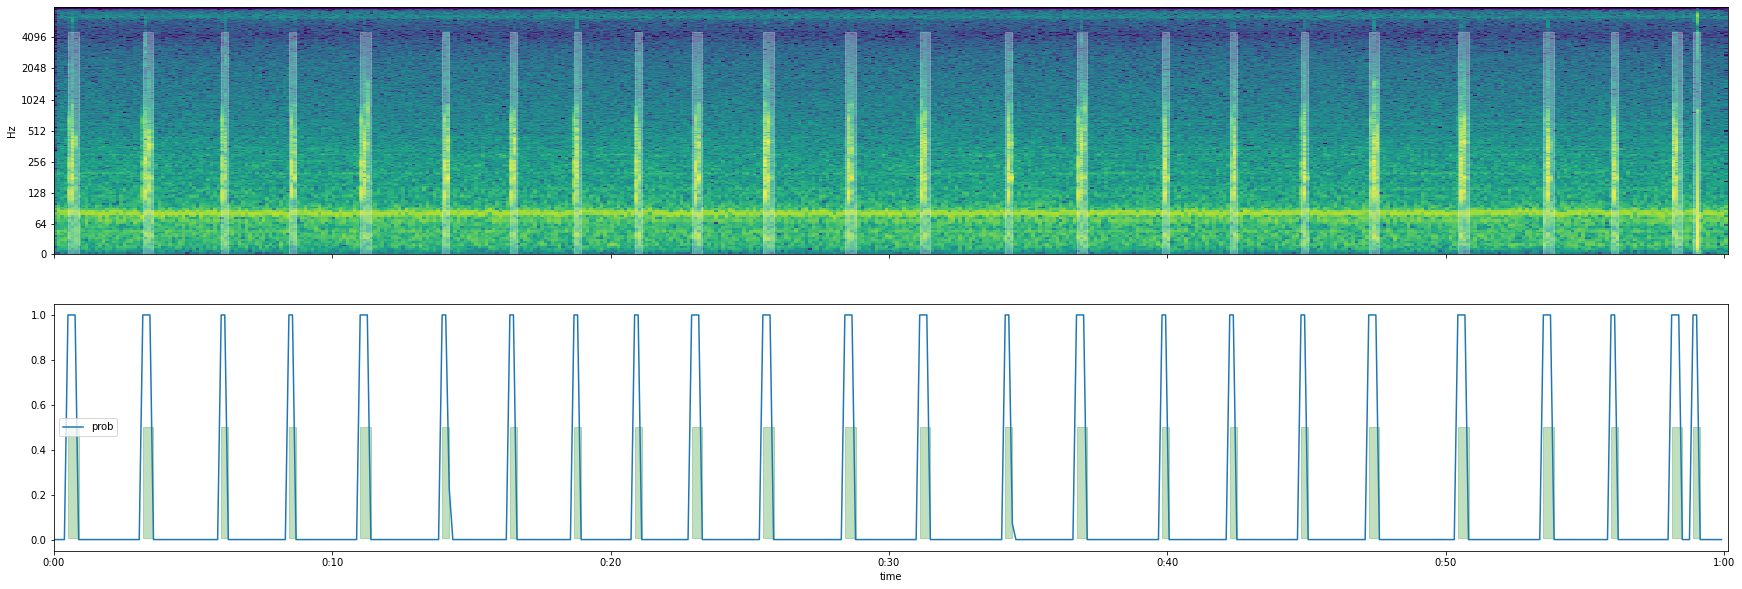

In [33]:

def power_log(x):
    return 2**(math.ceil(math.log(x, 2)))


# TODO: label sections from couple different part of the file
# for example once per 15 or 30 minutes?
# can find length using soundfile.SoundFile(path)
def autolabel(path, window_length=0.256/2, sr=16000):
    sr = 16000
    
    plots = 2
    height = 5
    fig, axs = plt.subplots(plots, figsize=(30, height*plots), sharex=True)
    
    event_length = window_length
    
    # Load audio
    audio, sr = librosa.load(path, offset=0, duration=1*60, sr=sr)
    
    # Plot spectrogram
    spec_hop = int(0.125 * sr)
    spec_fft = power_log(spec_hop*2)
    stft = librosa.stft(audio, hop_length=spec_hop, n_fft=spec_fft)
    spec = librosa.amplitude_to_db(numpy.abs(stft), ref=numpy.max)
    
    ax = axs[0]
    librosa.display.specshow(spec, ax=ax, hop_length=spec_hop, sr=sr, y_axis='log', x_axis='time', cmap='viridis')
    
    #print("Duration: ", len(audio)/sr)
    
    # Compute features
    feature_hop = int(window_length*16000)
    feature_fft = power_log(feature_hop*2)
    
    # MFCC
    ff = librosa.feature.mfcc(audio, sr=sr, hop_length=feature_hop, n_fft=feature_fft, n_mfcc=13) 
    delta = librosa.feature.delta(ff, width=7, order=1)
    ff = numpy.concatenate([ff, delta], axis=0)
    
    # Label the sequence
    hmm = find_events(ff.T)

    # Sort outputs such that highest volumes is always class 1    
    energy = librosa.feature.rms(audio, hop_length=feature_hop).T
    e1 = energy[hmm.prob > 0.5]
    e0 = energy[hmm.prob < 0.5]
    if numpy.median(e0) > numpy.median(e1):
        hmm['prob'] = 1.0 - hmm.prob

    # Times
    t = librosa.core.frames_to_time(numpy.arange(ff.shape[1]), hop_length=feature_hop, sr=sr)

    
    ax = axs[1]
    df = pandas.DataFrame({
        'prob': hmm.prob,
        'time': t,
    })
    df.plot(ax=ax, x='time')
    series = df.set_index('time')['prob']

    on_threshold = 0.5
    off_threshold = 0.4

    sparse, dense = utils.mark_onoff(series, on_threshold=on_threshold, off_threshold=off_threshold)
    sparse

    # Evaluation
    distances = sparse[sparse==1].reset_index()['index'].diff(1)

    duration = len(audio)/sr
    expected = math.floor(duration / distances.median())
    print('Event distances:', distances.mean(), distances.std()/distances.mean() )
    print('Events expected', expected)
    print('Events gotten', len(distances), (len(distances)/expected)*100, '%')
    
    lab = utils.join_events(sparse)
    lab['annotation'] = 'p'
    lab

    ax = axs[0]
    plot_time_spans(axs[0], lab, color='white', alpha=0.25, ymax=0.9, ymin=-0.1)
    plot_time_spans(axs[1], lab, color='green', alpha=0.25, ymax=0.5, ymin=0.05)
    
    fig.savefig("labels11.png", bbox_inches='tight', pad_inches=0)
    
    labels.write(lab, 'labels11.txt')

    
autolabel(files.iloc[1].path)

NameError: name 'df' is not defined

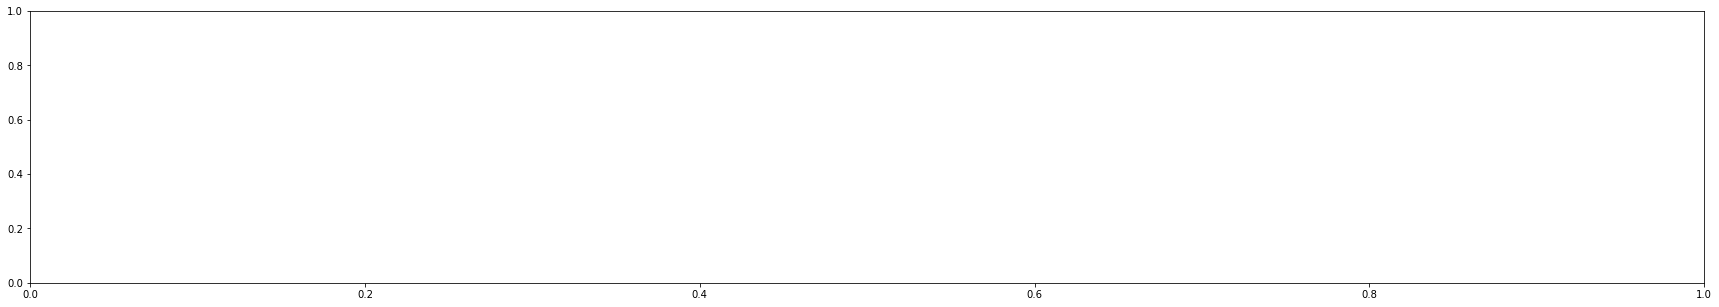

In [22]:

fig, ax = plt.subplots(1, figsize=(30, 5))
df.plot(ax=ax, y='dist', x='time')
ax.axhline(y=-0.75, color='red')
plot_time_spans(ax, lab, color='green', alpha=0.5)


In [30]:

labels.write(lab, 'labels2.txt')


In [163]:

feat = pandas.DataFrame(ff.T, index=t)
feat.columns = [ f'MFCC{i}' for i in feat.columns ]
feat['event'] = dense
feat

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,MFCC11,MFCC12,MFCC13,MFCC14,MFCC15,MFCC16,MFCC17,MFCC18,MFCC19,event
0.000,-687.394592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
0.256,-577.623779,50.038441,-88.097977,-60.402542,22.044508,15.759421,-9.095388,9.763987,5.340682,-29.518742,...,-0.186153,-0.961287,-1.643604,18.460224,21.351002,5.643793,6.052406,9.260145,-5.102694,0
0.512,-651.765564,8.690336,-39.401493,-15.760847,18.205084,5.133465,-6.531688,9.385270,7.857866,-12.882486,...,7.150213,4.008849,-3.208511,3.638898,4.233811,-5.536623,-4.251554,3.028214,-0.081872,0
0.768,-687.394592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1.024,-686.918335,0.673183,0.672167,0.670475,0.668114,0.665083,0.661394,0.657053,0.652077,0.646456,...,0.633381,0.625950,0.617941,0.609373,0.600262,0.590633,0.580490,0.569868,0.558782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298.752,-424.784119,133.285416,-104.158676,-72.055832,-1.821957,-5.832156,-24.568821,20.817032,15.227757,-13.783329,...,14.367205,-0.093417,2.125749,26.139990,21.712574,12.025938,22.539663,20.177261,-4.619249,0
299.008,-311.157806,187.682724,-173.994431,-100.759445,17.808716,-27.255470,-54.728710,29.667408,17.170732,-30.898626,...,25.573048,-9.783409,-1.737396,31.132307,11.638620,2.032052,26.802107,17.879644,-8.057225,0
299.264,-574.338562,45.693398,-15.732926,15.756644,15.436896,12.033259,3.675159,27.715290,20.070156,2.448734,...,14.274140,6.555264,2.324006,10.724840,5.794532,-2.687727,0.451370,4.376207,1.129241,0
299.520,-600.801758,32.318676,1.756885,17.857212,5.755670,17.572292,6.933681,11.565662,6.914012,8.354190,...,7.787292,4.537599,4.564642,3.339089,6.155823,4.842264,2.216168,5.603010,2.327099,0


In [168]:

def build_model():
    
    import sklearn.pipeline
    import sklearn.preprocessing
    import sklearn.linear_model
    import sklearn.svm
    import sklearn.neighbors
    from sklearn.compose import make_column_transformer
    from sklearn.compose import make_column_selector
  
    from sklearn.experimental import enable_hist_gradient_boosting

    model = sklearn.pipeline.Pipeline([
        ('scale', sklearn.preprocessing.StandardScaler()),
        ('classifier', sklearn.linear_model.LogisticRegression()),
    ])

    return model

m = build_model()

feature_columns = [ c for c in feat.columns if c.startswith('MFCC') ]
m.fit(feat[feature_columns], feat[['event']])

/home/jon/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', LogisticRegression())])

In [174]:
Y_pred = m.predict(feat[feature_columns])
Y_pred.mean()

0.05716723549488054

In [175]:
import sklearn.metrics
sklearn.metrics.f1_score(feat[['event']], Y_pred)


0.9924812030075187

In [179]:
# TODO: put labeling code into a single function. Run for each input file
# TODO: setup test/val/train. Cross-validation with grouped split

pred = pandas.DataFrame({
  'probability': Y_pred,
}, index=feat.index)
pred

,probability
0.000,0
0.256,0
0.512,0
0.768,0
1.024,0
...,...
298.752,0
299.008,0
299.264,0
299.520,0


array([[<AxesSubplot:title={'center':'index'}>,
        <AxesSubplot:title={'center':'probability'}>]], dtype=object)

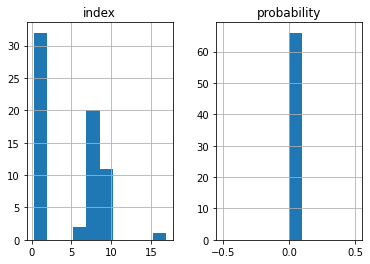

In [184]:
pred[pred.probability == 1].reset_index().diff().hist()

In [348]:
        
pred['class'] = (pred.probability > 0.5).astype(int)
merged = utils.merge_consecutive(pred, col='class')
merged
merged[merged['class'] == 1]

,start,end,class
1,3.072,3.584,1
3,11.264,11.520,1
5,19.456,19.968,1
7,28.416,28.672,1
9,35.840,36.352,1
11,43.776,44.288,1
13,52.736,53.248,1
15,61.696,62.208,1
17,70.144,70.656,1
19,77.312,77.824,1


<AxesSubplot:>

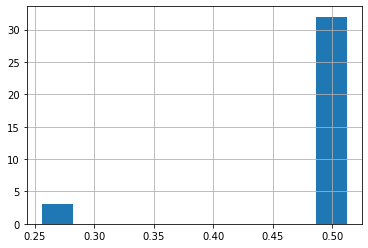

In [213]:
pos = merged[merged['class'] == 1]
(pos['end']-pos['start']).hist()

In [186]:
8/event_length

31.25

ValueError: x is required to have ndim 1 but has ndim 2

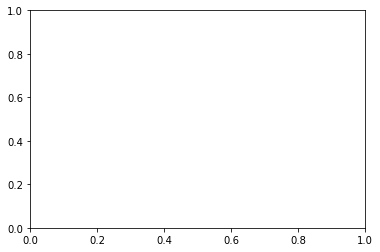

In [349]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(pred, zero=False)

In [ ]:
# TODO: make predictions on whole files


<AxesSubplot:xlabel='time'>

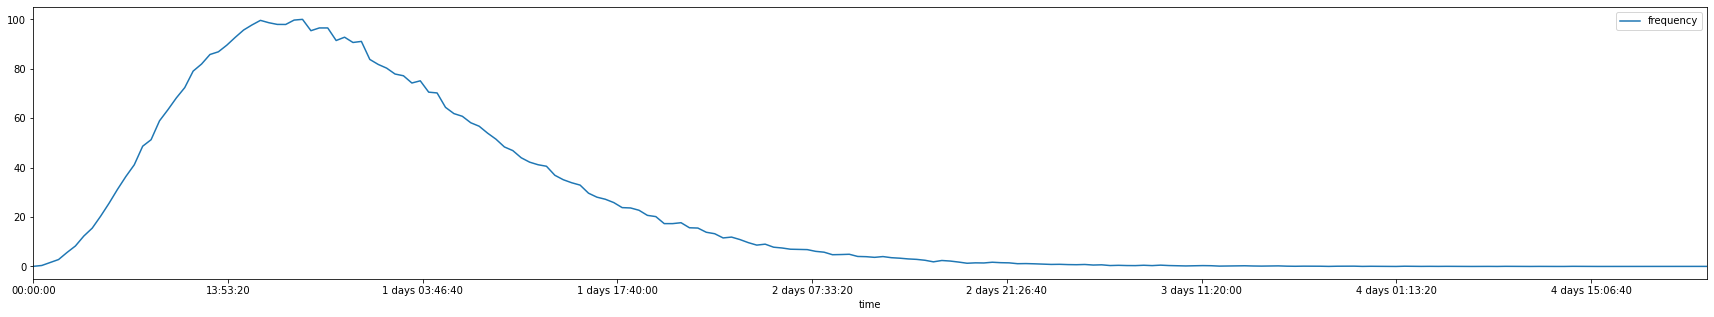

In [75]:

f = beerbubble.synthesize_fermentation_rate()
fig, ax = plt.subplots(1, figsize=(30, 5))
f.plot(ax=ax)


<AxesSubplot:xlabel='time'>

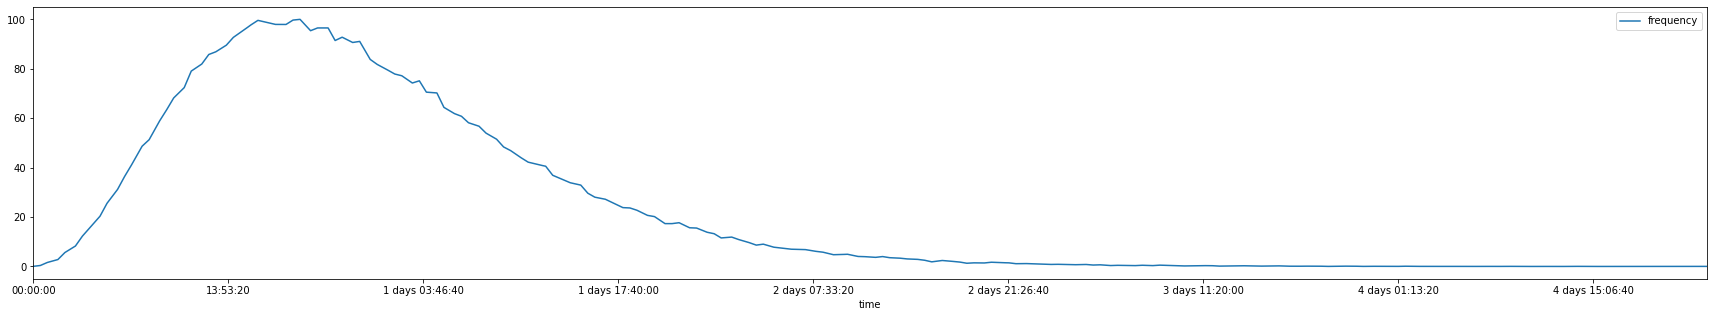

In [79]:
fig, ax = plt.subplots(1, figsize=(30, 5))
f.resample('15min').mean().interpolate().plot(ax=ax)

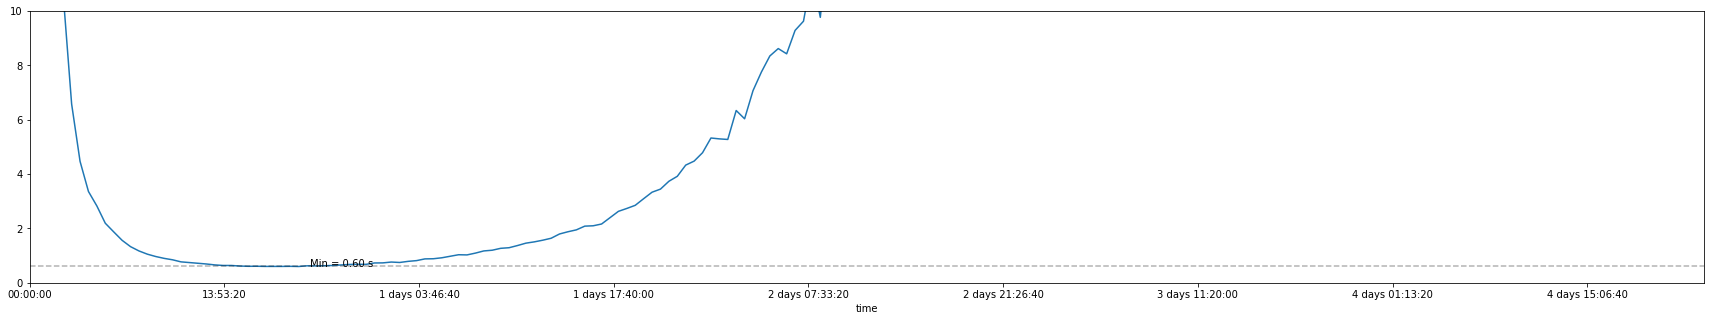

In [353]:

def plot_time_between(df):

    fig, ax = plt.subplots(1, figsize=(30, 5))
    df.plot(ax=ax)
    ax.set(ylim=(0, 10))
    min_time = time_between.min()
    min_pos = pandas.to_timedelta(20, unit='hour')

    ax.axhline(y=min_time, color='black', alpha=0.3, ls='--')
    ax.text(y=min_time, x=min_pos.total_seconds()*1e9, s=f'Min = {min_time:.2f} s')

time_between = (1/f.frequency) * 60
    
plot_time_between(time_between)

In [365]:
    
ee = beerbubble.generate_events(time_between[time_between != numpy.inf])
ee['sec'] = ee['time'].dt.total_seconds()
ee

,time,sec
0,0 days 00:01:25.124226064,85.124226
1,0 days 00:02:50.253800980,170.253801
2,0 days 00:04:15.250416660,255.250417
3,0 days 00:05:40.357046369,340.357046
4,0 days 00:07:05.396618883,425.396619
...,...,...
163795,4 days 20:49:09.783680904,420549.783681
163796,4 days 21:33:06.807546196,423186.807546
163797,4 days 22:17:03.778686445,425823.778686
163798,4 days 23:01:00.862934850,428460.862935


<AxesSubplot:xlabel='time'>

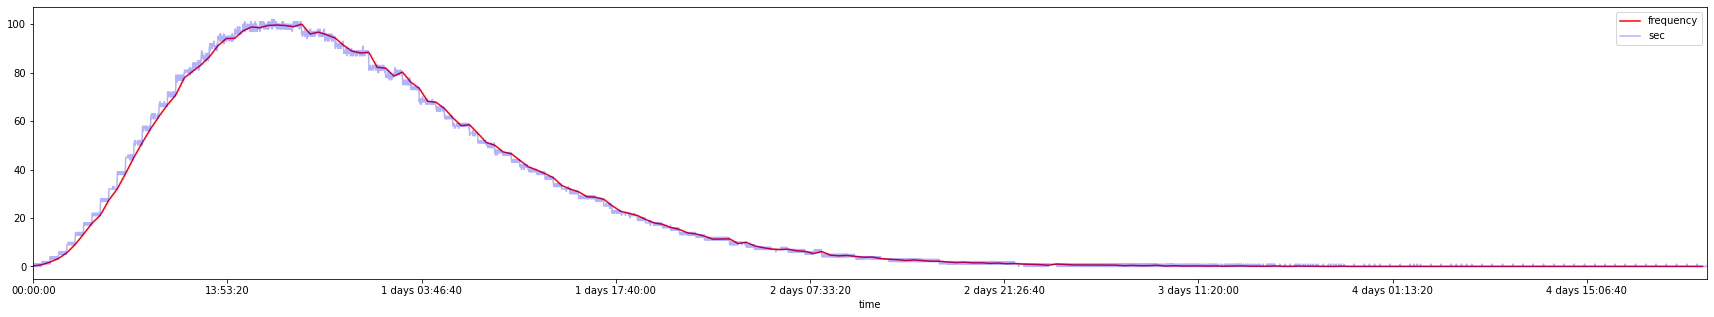

In [366]:
et = ee.set_index('time')
fig, ax = plt.subplots(1, figsize=(30, 5))
f.plot(ax=ax, color='red')
et.resample('1min').count().plot(ax=ax, color='blue', alpha=0.3)